In [1]:
import numpy as np
import pickle
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [4]:
# Define the root directory
name = 'Dataset-ppi--RE-True--W-1--Epochs-4000--D-2--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
# W = True

# load data

## get hierarchical structure of level 1

In [5]:

# Specify the variable names
# variable_names = ['k_exp_dist','final_idx', 'general_cl_id', 'general_mask']
variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
# Initialize a dictionary to store the loaded variables
loaded_variables = {}

# Loop through the variable names and load the data from pickle files
for var_name in variable_names:
    file_path = os.path.join(root, var_name + '.pkl')
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    loaded_variables[var_name] = loaded_data

# Access the loaded variables as needed
k_exp_dist = loaded_variables['k_exp_dist']
# final_idx = loaded_variables['final_idx']
general_cl_id = loaded_variables['general_cl_id']
general_mask = loaded_variables['general_mask']

### check data structure

In [6]:
k_exp_dist = np.array(k_exp_dist)
k_exp_dist.shape

(2082, 2082)

In [7]:
# check the cluster ids in different levels
for i in general_cl_id:
    a = list(set(i))
    print(a[0],a[-1])

0 9
10 29
30 69
70 149
150 309
512 511
616 1123
1124 1709
1710 2003
2048 2047
2060 2077
2080 2079


In [8]:
# check nodes in different levels, the position is map to general_cl_id cluster ids
for i in general_mask:
    a = list(set(i))
    print(max(a),min(a))

18757 0
18757 0
18757 0
18757 0
18757 0
18757 0
18757 0
18757 0
18755 0
18728 54
18683 191
18338 270


### take level 1 nodes

In [620]:
# check if the mask is ordered
if general_mask[0].tolist() != sorted(general_mask[0].tolist()):
    False

In [621]:
# since the general_mask[0] is ordered, we can directly use list index as the node id
L1 = general_cl_id[0]
unique_values = np.unique(L1)
index_dict = {value: np.where(L1 == value)[0].tolist() for value in unique_values}

In [622]:
for key, value in index_dict.items():
    print(f"Key: {key}, Value Length: {len(value)}")

Key: 0, Value Length: 1016
Key: 1, Value Length: 1719
Key: 2, Value Length: 2653
Key: 3, Value Length: 1953
Key: 4, Value Length: 1783
Key: 5, Value Length: 1740
Key: 6, Value Length: 2341
Key: 7, Value Length: 1763
Key: 8, Value Length: 1053
Key: 9, Value Length: 2746


### hierarchical structure of level 1

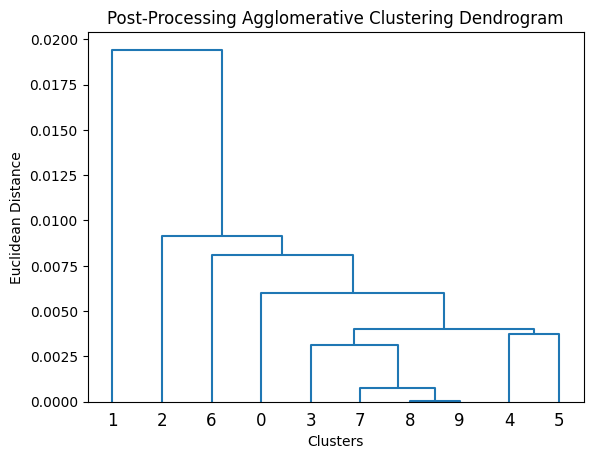

In [623]:

pltroot = 'D:/study/thesis/project/HBDM-main/ppi_results/plots/'

# Create your matrix of within-cluster Euclidean distances
distance_matrix = k_exp_dist[:10,:10]

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='average')
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)

plt.title('Post-Processing Agglomerative Clustering Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distance')
plt.savefig(pltroot+'Dendrogram-'+name+'.png')
plt.show()

order = dendrogram['leaves']

### get node order

In [624]:
index = []
for key in order:
    index.extend(index_dict[key])

In [625]:
len(index)

18767

## latent representation

In [626]:
### get node and 1d,2d

file_path_2d = 'D:/study/thesis/project/HBDM-main/ppi_results/latent/'+name +'.pkl'
with open(file_path_2d, 'rb') as file:
    loaded_tensor = pickle.load(file)

tensor = loaded_tensor.cpu()
# Now you can convert it to a NumPy array
node_rep = tensor.detach().numpy()
df_latent = pd.DataFrame({'1d': node_rep.T[0], '2d': node_rep.T[1]})
df_latent['node'] = df_latent.index

In [627]:
## get node and cluster
clusters = []
ori_index = []
for key in index_dict:
    clusters += len(index_dict[key])*[int(key)]
    ori_index.extend(index_dict[key])
df = pd.DataFrame({'node': ori_index, 'cluster': clusters})

In [628]:
## get df: node, cluster, 1d, 2d
df = df.merge(df_latent)
df = df.sort_values(by='node')
df.head(5)

,node,cluster,1d,2d
1016,0,1,-1.915149,-0.014530
2735,1,2,-1.343964,1.239075
16021,2,9,0.526151,-2.143712
0,3,0,-9.346293,-0.976955
1017,4,1,-4.390655,-1.563324


# Visualization

## read original adjacency matrix

In [629]:
# if W is True:
#     sparse_i = []
#     sparse_j = []
#     for level in range(1,10):
#         inputfile = 'D:/study/thesis/project/HBDM-main/datasets/ppi/level_'+str(level)
#         sparse_i_level=np.loadtxt(inputfile+'_sparse_i.txt').astype(int)
#         # input data, link column positions with i<j
#         sparse_j_level=np.loadtxt(inputfile+'_sparse_j.txt').astype(int)
#         sparse_i.extend(sparse_i_level)
#         sparse_j.extend(sparse_j_level)
# else:
#     path1=r'D:\study\thesis\project\HBDM-main\datasets\ppi\sparse_i.txt'
#     path2=r'D:\study\thesis\project\HBDM-main\datasets\ppi\sparse_j.txt'
#     # Step 1: Read data from sparse_i and sparse_j files
#     sparse_i = np.loadtxt(path1)
#     sparse_j = np.loadtxt(path2)
#     sparse_i = sparse_i.astype(int)
#     sparse_j = sparse_j.astype(int)

path1=r'D:\study\thesis\project\HBDM-main\datasets\ppi\sparse_i.txt'
path2=r'D:\study\thesis\project\HBDM-main\datasets\ppi\sparse_j.txt'
# Step 1: Read data from sparse_i and sparse_j files
sparse_i = np.loadtxt(path1)
sparse_j = np.loadtxt(path2)
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)


In [630]:
# ## ad 
# ad = coo_array((57508*[1], (np.concatenate((sparse_i, sparse_j)), np.concatenate((sparse_j, sparse_i)))), shape=(20111, 20111)).toarray()

In [631]:
## G
G = nx.Graph()
edges = zip(sparse_i, sparse_j)
G.add_edges_from(edges)

In [632]:
len(sparse_i)

805326

In [633]:
len(G.nodes)

18767

## adjacency matrix visualization: original vs ordered

C:\Users\ZZY\AppData\Local\Temp\ipykernel_13744\710690624.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adjacency_matrix = nx.to_numpy_array(G, dtype=np.bool)


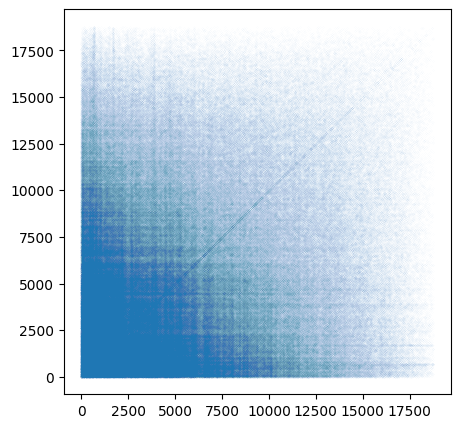

In [634]:
adjacency_matrix = nx.to_numpy_array(G, dtype=np.bool)
coords = np.argwhere(adjacency_matrix==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.00005)
# plt.savefig(pltroot+name+'.png')
plt.show()


C:\Users\ZZY\AppData\Local\Temp\ipykernel_13744\1408844357.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ad = nx.to_numpy_array(G, dtype=np.bool, nodelist=index)


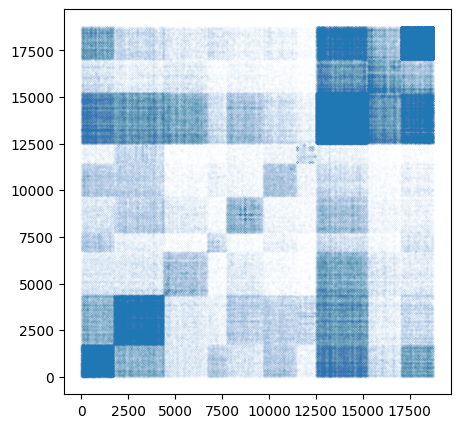

In [635]:
ad = nx.to_numpy_array(G, dtype=np.bool, nodelist=index)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.00005)
plt.savefig(pltroot+'ordered-'+name+'.png')
plt.show()

## cluster zoom

In [636]:
def show_cluster(df):
    colors = plt.cm.Paired(np.linspace(0, 1, 10))  # You can choose a different colormap if you prefer

    # Create a color map dictionary
    color_map = {i: colors[i] for i in range(10)}

    # Create a scatter plot
    plt.scatter(df['1d'], df['2d'], c=df['cluster'].map(color_map), cmap='Paired',s=0.1)

    # Add labels and a legend
    plt.xlabel('1d')
    plt.ylabel('2d')

    # Create a legend with labels based on unique clusters
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=cluster, 
                                markerfacecolor=color_map[cluster], markersize=10) for cluster in df['cluster'].unique()]
    plt.legend(handles=legend_labels)
    plt.savefig(pltroot+'cluster-'+name+'.png')
    # Show the plot
    plt.show()


In [637]:
# show_cluster(df)

C:\Users\ZZY\AppData\Local\Temp\ipykernel_13744\4219677278.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['1d'], df['2d'], c=df['cluster'].map(color_map), cmap='Paired',s=0.1)


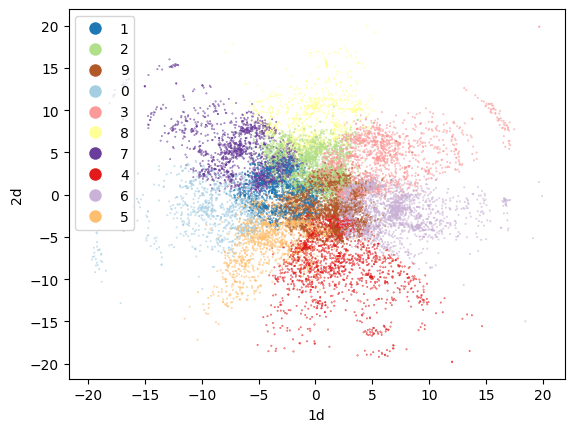

In [638]:
subdf = df[(df['1d'] > -20) & (df['1d'] < 20) & (df['2d'] > -20) & (df['2d'] < 20)]
show_cluster(subdf)

In [639]:

# #Plot adjacency matrix in toned-down black and white
# fig = plt.figure(figsize=(5, 5)) # in inches
# plt.imshow(ad,
#                 cmap="Greys",
#                 interpolation='none')

# Test

## choose test dataset

In [640]:
with open(r'D:\study\thesis\project\HBDM-main\datasets\ppi\ppi_index.pkl', 'rb') as f:
    value_to_index_mapping = pickle.load(f)
with open(r'D:\study\thesis\project\HBDM-main\datasets\ppi\Aliases2stringId.pkl', 'rb') as f:
    ppi_name2stringId = pickle.load(f)

### from STRING-KEGG

In [641]:
# test_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\CAD\KEGG Lipid and atherosclerosis.tsv',sep='\t')
# group = set(test_df['#node1'].unique())
# group.update(set(test_df['node2'].unique()))
# group = list(group)

# group_node = []
# for gene in group:
#     stringid = ppi_name2stringId[gene]
#     node = value_to_index_mapping[int(stringid[9:])]
#     group_node.append(node)

### from STRING cluster

In [642]:
# string_15942=pd.read_csv(r'D:\study\thesis\project\HBDM-main\string module\9606.clusters.proteins.v12.0.txt',sep='\t')
# string_15942 = string_15942[string_15942['cluster_id'] == 'CL:15942']
# group_node = []
# for i in string_15942['protein_id']:
#     node = value_to_index_mapping[int(i[9:])]
#     group_node.append(node)

### from DisGeNET disease

In [643]:
disease_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\Coronary artery disease.tsv',sep='\t')

In [644]:
names = set(ppi_name2stringId.keys())
humans = set(value_to_index_mapping.keys())

group_node = []
for gene in disease_df['Gene']:
    if gene in names:
        stringid = ppi_name2stringId[gene]
        stringid = int(stringid[9:])
        if stringid in humans:
            node = value_to_index_mapping[stringid]
            group_node.append(node)

## label df with given group_node

### check label position in latent space

In [645]:
group_df = df[df['node'].isin(group_node)]
group_df['cluster'].unique()

array([8, 2, 9, 1, 3, 7, 5, 6, 4, 0], dtype=int64)

In [646]:
## get final df: node, cluster, 1d, 2d, label
df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
# Set the index to match the values in column 'node'
df = df.set_index('node')
# Reset the index to its default integer index
df = df.reset_index()

In [647]:
def show_positive(df):
    # Define the color map
    color_map = {0: 'grey', 1: 'red'}

    # Create a scatter plot
    plt.scatter(df['1d'], df['2d'], c=df['label'].map(color_map), s=0.1, label='Data Points')

    # Add labels
    plt.xlabel('1d')
    plt.ylabel('2d')


    # Set plot title
    plt.title('Scatter Plot of 1d vs. 2d')

    # Show the plot
    plt.grid(True)
    plt.savefig(pltroot+'positive-'+name+'.png')
    plt.show()

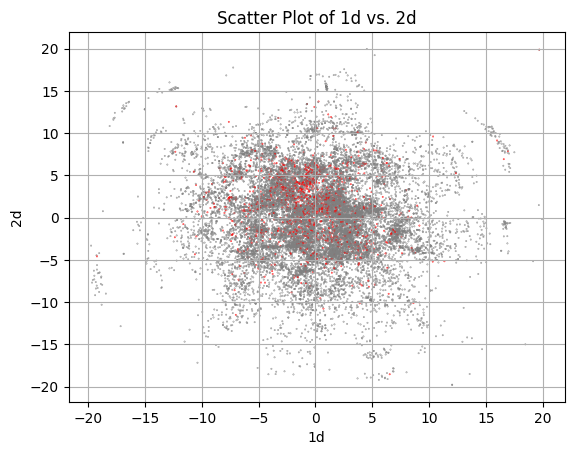

In [648]:
show_positive(df[(df['1d'] > -20) & (df['1d'] < 20) & (df['2d'] > -20) & (df['2d'] < 20)])
# show_positive(df)

## k nearest neighbor method

In [649]:
import random
from sklearn.neighbors import KDTree

### 5-fold corss validation get best K

In [650]:
output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+name+".txt"

In [651]:
len(df)

18767

In [652]:
from sklearn.model_selection import KFold

# Define your range of k values and leaf_size values
k_values = [2, 3, 4, 5, 6, 7, 8, 9]


# Split your data into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
with open(output_file, "w") as f:
    for k in k_values:
        k+=1
        precision_scores = []
        coverage_scores = []
        random_precision_scores = []
        random_coverage_scores = []

        # Build a k-d tree from the points
        kdtree = KDTree(df[['1d', '2d']].to_numpy(), leaf_size=20)
        for train_index, test_index in kf.split(group_node):
            train_nodes = [group_node[i] for i in train_index]
            test_nodes = [group_node[i] for i in test_index]

            start = []
            dist = []
            neighbor = []
            random_nodes = []
            for i in train_nodes:
                given_point = df[df['node']==i][['1d', '2d']].to_numpy()
                # Perform a k-NN search to find the k+1 nearest neighbors
                distances, indices = kdtree.query(given_point, k=k)
                start += (k-1)*[i]
                dist += distances.reshape(-1).tolist()[1:]
                neighbor += indices.reshape(-1).tolist()[1:]

                random_nodes += random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

            neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
            cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]
            
            # Append precision and coverage scores to lists
            precision_scores.append(len(cover_df) / len(neighbor_df))
            coverage_scores.append(len(cover_df['neighbor'].unique()) / len(test_nodes))
            
            ############################ random
            random_cover = []
            for j in random_nodes:
                if j in test_nodes:
                    random_cover.append(j)

            random_precision_scores.append(len(random_cover)/ len(random_nodes))
            random_coverage_scores.append(len(set(random_cover))/ len(test_nodes))

        ###### choose one fold to check details
        ranked = neighbor_df.sort_values(by='distance')
        coverage = 0
        for top_threshold in range(50, len(neighbor_df), 50):
            cover = []
            top_recommend = ranked['neighbor'].tolist()[:top_threshold]
            for i in top_recommend: 
                if i in test_nodes:
                    cover.append(i)
            if len(set(cover)) / len(test_nodes) > coverage:
                coverage = len(set(cover)) / len(test_nodes)
                top_precision = len(cover) / top_threshold
                print(f'top {top_threshold} precision: {top_precision}', file=f)
                print(f'top {top_threshold} coverage: {coverage}', file=f)
            else:
                print('coverage limitation', file=f)
                break
        # Calculate the average precision and coverage scores for the current k and leaf_size
        avg_precision = sum(precision_scores) / len(precision_scores)
        avg_coverage = sum(coverage_scores) / len(coverage_scores)

        random_avg_precision = sum(random_precision_scores) / len(random_precision_scores)
        random_avg_coverage = sum(random_coverage_scores) / len(random_coverage_scores)
        
        print(f"k={k-1}, leaf_size={20}",'\t',"Average Precision:", avg_precision,'\t',"Average Coverage:", avg_coverage)
        result_line = f"k={k-1}, leaf_size={20}\tAverage Precision: {avg_precision}\tAverage Coverage: {avg_coverage}\n"
        print(f"k={k-1}, leaf_size={20}\tRandom Precision: {random_avg_precision}\tRandom Coverage: {random_avg_coverage}", file=f)
        f.write(result_line)


k=2, leaf_size=20 	 Average Precision: 0.028583061889250815 	 Average Coverage: 0.1973941368078176
k=3, leaf_size=20 	 Average Precision: 0.028447339847991315 	 Average Coverage: 0.2736156351791531
k=4, leaf_size=20 	 Average Precision: 0.028094462540716614 	 Average Coverage: 0.3355048859934853
k=5, leaf_size=20 	 Average Precision: 0.02765472312703583 	 Average Coverage: 0.3811074918566775
k=6, leaf_size=20 	 Average Precision: 0.027660152008686212 	 Average Coverage: 0.4319218241042345
k=7, leaf_size=20 	 Average Precision: 0.028106095858538856 	 Average Coverage: 0.4840390879478827
k=8, leaf_size=20 	 Average Precision: 0.028481270358306186 	 Average Coverage: 0.5276872964169381
k=9, leaf_size=20 	 Average Precision: 0.02864639884183858 	 Average Coverage: 0.5537459283387622


In [653]:
# k=9
# num_to_test = int(len(group_node) * 0.8)

# start_nodes = random.sample(group_node, num_to_test)
# test_nodes =  list(set(group_node) - set(start_nodes))

# # Build a k-d tree from the points
# kdtree = KDTree(df[['1d', '2d']].to_numpy(), leaf_size=20)
# k+=1
# start = []
# dist = []
# neighbor = []
# for i in start_nodes:
#     given_point = df[df['node']==i][['1d', '2d']].to_numpy()
#     # Perform a k-NN search to find the k+1 nearest neighbors
#     distances, indices = kdtree.query(given_point, k=k)
#     start += (k-1)*[i]
#     dist += distances.reshape(-1).tolist()[1:]
#     neighbor += indices.reshape(-1).tolist()[1:]

# neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
# cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]

# print(k-1,' precision: ',len(cover_df)/len(neighbor_df))
# print(k-1,' coverage: ',len(cover_df['neighbor'].unique())/len(test_nodes))

In [654]:
len(set(ranked['neighbor'].tolist()[:50]))

48

In [655]:
len(set(ranked['neighbor'].tolist()[:50])&set(test_nodes))

3

In [656]:
len(test_nodes)

307

In [657]:
len(neighbor_df)

11052

In [658]:
ranked

,start,neighbor,distance
9018,9613,17229,0.000549
9648,717,14272,0.000948
8694,7837,4993,0.001066
4752,16365,2730,0.001115
4680,2730,16365,0.001115
...,...,...,...
3784,13339,18099,5.005227
3785,13339,8569,5.030655
3786,13339,5598,5.109337
3787,13339,18001,5.503639


## PU classifier

In [659]:
# X = df[['1d', '2d']].to_numpy()
# y = df['label'].to_numpy()

In [660]:
# from pulearn import WeightedElkanotoPuClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.model_selection import StratifiedKFold

# svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
# pu_estimator = WeightedElkanotoPuClassifier(
#     estimator=svc, labeled=10, unlabeled=20, hold_out_ratio=0.2)


# # Initialize stratified k-fold cross-validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store cross-validation scores
# pu_f1_scores = []

# # Perform cross-validation
# for train_index, test_index in kf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     pu_estimator.fit(X_train, y_train)
#     y_pred = pu_estimator.predict(X_test)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(
#         y_test, y_pred)
#     pu_f1_scores.append(f1_score[1])
#     print("F1 score: {}".format(f1_score[1]))
#     print("Precision: {}".format(precision[1]))
#     print("Recall: {}".format(recall[1]))

# plt.plot(pu_f1_scores, label='PU')

